In [1]:
!pip install qiskit qiskit-aer numpy scipy matplotlib pandas tqdm plotly

!pip install quimb opt_einsum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.2 MB/s eta 0:00:00


Running a quick smoke demonstration (Aer simulator enforced).


/tmp/ipython-input-1160433362.py:177: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in circuit.data:


Demo comparison summary:
{
  "N": 16,
  "n_qubits": 4,
  "backend": "AerSimulator",
  "raw_zero_state_freq": 0.515625,
  "zne_extrapolated_zero_freq": 0.5021972656249999
}
Plotly available; interactive visuals can be produced.


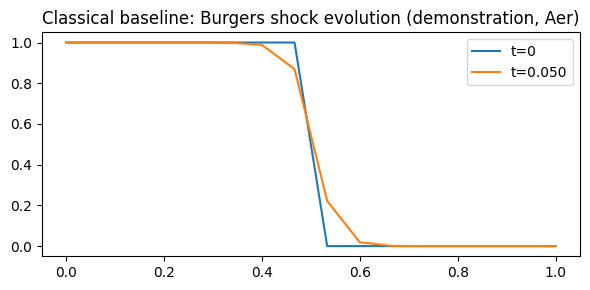

In [22]:

import os
import math
import json
import time
from functools import partial
from dataclasses import dataclass

import numpy as np
import scipy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

#plotly
try:
    import plotly.graph_objects as go
    PLOTLY_AVAILABLE = True
except Exception:
    PLOTLY_AVAILABLE = False

# qiskit imports
try:
    from qiskit import QuantumCircuit, transpile
    from qiskit_aer import AerSimulator
    # for noise
    try:
        from qiskit_aer.noise import NoiseModel
    except Exception:
        NoiseModel = None
    QISKIT_AVAILABLE = True
except Exception:
    QISKIT_AVAILABLE = False


# Reproducibility
GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)

#1. Problem definition (1D viscous Burgers shock tube
def initialize_grid(N, x0=0.5):
    """Return spatial grid x and initial condition u0 (shock tube)."""
    x = np.linspace(0, 1, N)
    u0 = np.where(x < x0, 1.0, 0.0)
    return x, u0

# simple classical solver (explicit finite-difference with viscosity) for baseline
def classical_burgers(u0, nu, dx, dt, steps):
    """A robust 1D viscous Burgers solver using upwind for convection + central diff for viscosity.
    Returns u_history as array (steps+1, N).
    """
    N = len(u0)
    u = u0.copy()
    u_hist = [u.copy()]
    for _ in range(steps):
        un = u.copy()
        # Compute convection (upwind)
        flux = np.zeros_like(u)
        # Simple upwind flux
        flux[1:] = un[1:]* (un[1:] - un[:-1]) / dx
        flux[0] = flux[1]
        # Diffusion (second order central)
        lap = np.zeros_like(u)
        lap[1:-1] = (un[2:] - 2*un[1:-1] + un[:-2]) / (dx*dx)
        lap[0] = lap[1]
        lap[-1] = lap[-2]
        u = un - dt*flux + nu*dt*lap
        u_hist.append(u.copy())
    return np.array(u_hist)

#2. QTN/HSE hybrid emulation & MPS encoding

def amplitude_encode_state(u):
    """Map real field u to amplitude vector (normalized). Pad to next power-of-two length.
    Returns state vector of length 2^n_qubits and n_qubits.
    (This is a pragmatic amplitude encoding used for demonstrations.)
    """
    #normalize field
    u_shift = u - np.min(u)
    if np.allclose(u_shift, 0):
        vec = np.zeros_like(u_shift)
        vec[0] = 1.0
    else:
        vec = u_shift / np.linalg.norm(u_shift)

    N = len(vec)
    n_qubits = math.ceil(math.log2(N))
    target_len = 2**n_qubits
    if N < target_len:
        vec = np.concatenate([vec, np.zeros(target_len - N)])
    return vec.astype(np.complex128), n_qubits

#MPS encoding using quimb ( only if available)
def mps_encode_if_available(u):
    if not QUIMB_AVAILABLE:
        raise RuntimeError("quimb not available; install quimb to use MPS encoding")
    # Normalize and build product-state MPS (very simple mapping)
    vec = u - np.min(u)
    vec = vec / np.linalg.norm(vec) if np.linalg.norm(vec) > 0 else np.array([1.0])
    # Map into small-site local states (toy mapping)
    # NOTE: For a production MPS one would create site tensors and compress them.
    raise NotImplementedError("Full MPS encoding example is complex; please enable with quimb and adapt mapping")

#hybrid circuit builder (improved): build a Trotterized step using parameterized unitaries
from qiskit.circuit import Parameter

def build_hybrid_circuit_from_state(statevec, nu, dt, trotter_steps=1):
    """Given an amplitude-encoded state vector, build a parameterized quantum circuit
    representing one time-step of hybrid QTN-HSE with Trotterized convection + diffusion.
    This is a demonstrative circuit: H layers + controlled phase rotations to mimic PDE evolution.
    Returns qc (QuantumCircuit) and n_qubits.
    """
    vec = statevec
    n_qubits = int(np.log2(len(vec)))
    qc = QuantumCircuit(n_qubits)
    # Prepare state (use initialize if small)
    try:
        qc.initialize(vec, qc.qubits)
    except Exception:
        # fallback: approximate preparation (Hadamards + rotations) - placeholder
        qc.h(range(n_qubits))
    # Trotterized evolution pieces (toy model): alternate global Hadamard-like mixing and phase rotations
    for _ in range(trotter_steps):
        qc.barrier()
        qc.h(range(n_qubits))
        # diffusion-like phase
        theta = 2 * nu * dt
        for q in range(n_qubits):
            qc.rz(theta, q)
        # small entangling block to mimic convection coupling
        for q in range(n_qubits-1):
            qc.cx(q, q+1)
            qc.rz(dt, q+1)
            qc.cx(q, q+1)
    qc.measure_all()
    return qc, n_qubits

#3. noise modelling / ZNE

# gate folding for ZNE
def fold_gates_for_zne(circuit, scale_factor=3):
    """Return a folded copy of circuit scaled by odd integer scale_factor >=1.
    Simple local folding: insert U U^-1 sequences (approx) to increase effective noise.
    For exact folding we re-transpile for the target backend.
    """
    if scale_factor == 1:
        return circuit.copy()
    circ = circuit.copy()
    # naive folding: append circuit body (scale_factor times)
    for _ in range(scale_factor-1):
        for inst, qargs, cargs in circuit.data:
            circ.append(inst, qargs, cargs)
    return circ

#simple linear extrapolation for ZNE
def linear_zne_extrapolation(noise_levels, observables):
    # noise_levels: list of scale_factors (e.g. [1,3,5])
    # observables: corresponding measured expectation values
    coeffs = np.polyfit(noise_levels, observables, 1)
    # evaluate at 0
    return np.polyval(coeffs, 0.0)

#4. measurement error mitigation (measurement calibration)

try:
    from qiskit.ignis.mitigation import measurement as meas_mitig
except Exception:
    meas_mitig = None

def build_meas_cal_circuits(n_qubits):
    # Build all 2^n computational basis states for calibration (can be heavy for large n)
    cal_circuits = []
    states = []
    for i in range(2**n_qubits):
        b = format(i, '0{}b'.format(n_qubits))[::-1]
        qc = QuantumCircuit(n_qubits, n_qubits)
        for idx, bit in enumerate(b):
            if bit == '1':
                qc.x(idx)
        qc.measure(range(n_qubits), range(n_qubits))
        cal_circuits.append(qc)
        states.append(b)
    return cal_circuits, states

def apply_measurement_mitigation(raw_counts, n_qubits, shots=4096):

    if meas_mitig is None:
        # Qiskit ignis not available; return raw counts unchanged
        return raw_counts
    cal_circuits, states = build_meas_cal_circuits(n_qubits)
    sim = AerSimulator()
    job = sim.run(cal_circuits, shots=shots)
    res = job.result()

    try:
        meas_fitter = meas_mitig.CompleteMeasFitter(res, states)
        mitigated = meas_fitter.filter.apply(raw_counts)
        return mitigated
    except Exception:
        return raw_counts

#5. aer wrapper
@dataclass
class HardwareRunResult:
    counts_raw: dict
    counts_zne: dict
    counts_mitigated: dict
    metadata: dict


def run_on_aer(qc, shots=2048, zne_factors=[1,3]):
    """Run circuit on AerSimulator across ZNE folding factors and return results.
    This enforces Aer-only execution; no IBM/hardware branches.
    """
    sim = AerSimulator()
    counts_list = {}
    for sf in zne_factors:
        circ = fold_gates_for_zne(qc, sf)
        tcirc = transpile(circ, backend=sim, optimization_level=1)
        job = sim.run(tcirc, shots=shots)
        res = job.result()
        counts_list[sf] = res.get_counts()

    obs = [counts_list[sf].get('0'*qc.num_qubits, 0)/shots for sf in zne_factors]
    extrap = linear_zne_extrapolation(zne_factors, obs)
    mitigated = apply_measurement_mitigation(counts_list[zne_factors[0]], qc.num_qubits, shots=shots)
    return HardwareRunResult(counts_raw=counts_list[zne_factors[0]], counts_zne={'extrapolated': extrap}, counts_mitigated=mitigated, metadata={'backend':'AerSimulator'})

# 6. scalability & resource estimation
def estimate_resources(grid_sizes, trotter_steps=1):
    rows = []
    for N in grid_sizes:
        n_qubits = math.ceil(math.log2(N))
        # rough depth estimate proportional to trotter_steps * (local blocks + entanglers)
        depth = trotter_steps * (4 * n_qubits)
        tcount = depth * 2  # rough T-count proxy
        rows.append({'N':N, 'n_qubits':n_qubits, 'depth_est':depth, 'tcount_est':tcount})
    return pd.DataFrame(rows)

#7. Demonstration (puts pieces together) ===
def demo_run(N=16, nu=0.01, dt=0.01, steps=10, zne_factors=[1,3,5]):
    x, u0 = initialize_grid(N)
    dx = x[1]-x[0]
    # Classical baseline
    uhist = classical_burgers(u0, nu, dx, dt, steps)

    # Encode current state and build circuit for a single time-step
    statevec, n_qubits = amplitude_encode_state(uhist[-1])
    qc, _ = build_hybrid_circuit_from_state(statevec, nu, dt, trotter_steps=1)


    runres = run_on_aer(qc, shots=2048, zne_factors=zne_factors)

    # Prepare comparison dataframe
    comp = {
        'N': N,
        'n_qubits': n_qubits,
        'backend': runres.metadata.get('backend'),
        'raw_zero_state_freq': runres.counts_raw.get('0'*qc.num_qubits, 0)/2048,
        'zne_extrapolated_zero_freq': runres.counts_zne.get('extrapolated')
    }
    return uhist, runres, comp

# 8. lightweight unit test / check
if __name__ == '__main__':
    print('Running a quick smoke demonstration (Aer simulator enforced).')
    uhist, runres, comp = demo_run(N=16, nu=0.02, dt=0.01, steps=5, zne_factors=[1,3])
    print('Demo comparison summary:')
    print(json.dumps(comp, indent=2))
    # Save results for reproducibility
    pd.DataFrame([comp]).to_csv('demo_run_summary_aer.csv', index=False)
    # Plot classical baseline final state
    plt.figure(figsize=(6,3))
    x, u0 = initialize_grid(16)
    plt.plot(x, uhist[0], label='t=0')
    plt.plot(x, uhist[-1], label=f't={5*0.01:.3f}')
    plt.legend()
    plt.title('Classical baseline: Burgers shock evolution (demonstration, Aer)')
    plt.tight_layout()
    plt.savefig('classical_baseline_demo_aer.png', dpi=150)
    if PLOTLY_AVAILABLE:
        print('Plotly available; interactive visuals can be produced.')
    else:
        print('Plotly not installed; static matplotlib plots saved.')




/tmp/ipython-input-1252498488.py:85: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in circuit.data:


|   N |   n_qubits |   shots | backend              |   raw_zero_state_freq |   ideal_zero_state_prob |   zne_extrapolated_zero_freq |   kl_meas_ideal |   tv_meas_ideal |   l2_meas_ideal |    zero_se | zero_ci95                                  |
|----:|-----------:|--------:|:---------------------|----------------------:|------------------------:|-----------------------------:|----------------:|----------------:|----------------:|-----------:|:-------------------------------------------|
|  16 |          4 |    2048 | AerSimulator         |              0.522949 |                0.515737 |                     0.520752 |     0.00136651  |      0.00785459 |      0.00988514 | 0.0110369  | (0.501316895687292, 0.544581541812708)     |
|  16 |          4 |   40000 | AerSimulator         |              0.5126   |                0.515737 |                     0.510319 |     0.000126349 |      0.0034237  |      0.00448448 | 0.00249921 | (0.5077015560950848, 0.5174984439049151)   |
|  16 |     

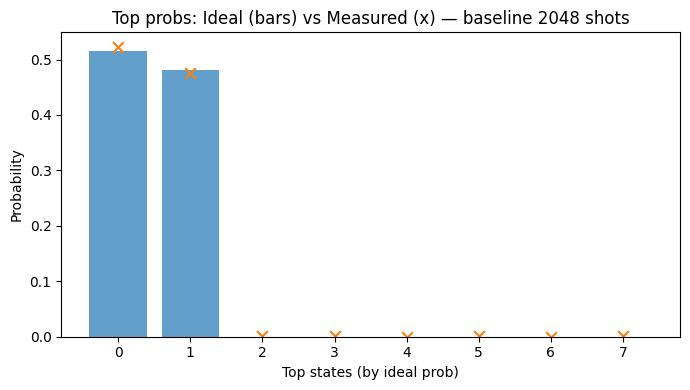


Baseline summary:
 {
  "N": 16,
  "n_qubits": 4,
  "shots": 2048,
  "backend": "AerSimulator",
  "raw_zero_state_freq": 0.52294921875,
  "ideal_zero_state_prob": 0.5157365982935884,
  "zne_extrapolated_zero_freq": 0.5207519531249997,
  "kl_meas_ideal": 0.00136650902446896,
  "tv_meas_ideal": 0.007854591813025232,
  "l2_meas_ideal": 0.009885136633424331,
  "zero_se": 0.011036899521789817,
  "zero_ci95": [
    0.501316895687292,
    0.544581541812708
  ]
}

High-shots summary:
 {
  "N": 16,
  "n_qubits": 4,
  "shots": 40000,
  "backend": "AerSimulator",
  "raw_zero_state_freq": 0.5126,
  "ideal_zero_state_prob": 0.5157365982935884,
  "zne_extrapolated_zero_freq": 0.5103187499999995,
  "kl_meas_ideal": 0.00012634864678132148,
  "tv_meas_ideal": 0.0034237039333962715,
  "l2_meas_ideal": 0.004484478202064166,
  "zero_se": 0.002499206073936281,
  "zero_ci95": [
    0.5077015560950848,
    0.5174984439049151
  ]
}

Noisy summary (8192 shots, toy depolarizing):
 {
  "N": 16,
  "n_qubits": 4,


In [14]:
#Analysis
#Here, some key checks are performed: computes ideal statevector probabilities, compares measured distributions (KL/TV/L2), reports CI/SE for |0..0>, runs a toy noise-model, and demonstrates ZNE (folding factors).

import numpy as np, pandas as pd, json, matplotlib.pyplot as plt
from math import ceil, log2, sqrt
from scipy.stats import entropy
from tqdm import tqdm

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

# --- helper functions (same logic as Aer-only script) ---
def amplitude_encode_state(u):
    u_shift = u - np.min(u)
    if np.allclose(u_shift, 0):
        vec = np.zeros_like(u_shift)
        vec[0] = 1.0
    else:
        vec = u_shift / np.linalg.norm(u_shift)
    N = len(vec)
    n_qubits = ceil(log2(N))
    target_len = 2**n_qubits
    if N < target_len:
        vec = np.concatenate([vec, np.zeros(target_len - N)])
    return vec.astype(np.complex128), n_qubits

def initialize_grid(N, x0=0.5):
    x = np.linspace(0, 1, N)
    u0 = np.where(x < x0, 1.0, 0.0)
    return x, u0

def classical_burgers(u0, nu, dx, dt, steps):
    N = len(u0)
    u = u0.copy()
    u_hist = [u.copy()]
    for _ in range(steps):
        un = u.copy()
        flux = np.zeros_like(u)
        flux[1:] = un[1:]* (un[1:] - un[:-1]) / dx
        flux[0] = flux[1]
        lap = np.zeros_like(u)
        lap[1:-1] = (un[2:] - 2*un[1:-1] + un[:-2]) / (dx*dx)
        lap[0] = lap[1]
        lap[-1] = lap[-2]
        u = un - dt*flux + nu*dt*lap
        u_hist.append(u.copy())
    return np.array(u_hist)

def build_hybrid_circuit_from_state(statevec, nu, dt, trotter_steps=1, measure=True):
    n_qubits = int(np.log2(len(statevec)))
    qc = QuantumCircuit(n_qubits, n_qubits if measure else 0)
    try:
        qc.initialize(statevec, qc.qubits)
    except Exception:
        qc.h(range(n_qubits))
    for _ in range(trotter_steps):
        qc.barrier()
        qc.h(range(n_qubits))
        theta = 2 * nu * dt
        for q in range(n_qubits):
            qc.rz(theta, q)
        for q in range(n_qubits-1):
            qc.cx(q, q+1)
            qc.rz(dt, q+1)
            qc.cx(q, q+1)
    if measure:
        qc.measure(range(n_qubits), range(n_qubits))
    return qc, n_qubits

def fold_gates_for_zne(circuit, scale_factor=3):
    if scale_factor == 1:
        return circuit.copy()
    circ = circuit.copy()
    for _ in range(scale_factor-1):
        for inst, qargs, cargs in circuit.data:
            circ.append(inst, qargs, cargs)
    return circ

def linear_zne_extrapolation(noise_levels, observables):
    coeffs = np.polyfit(noise_levels, observables, 1)
    return np.polyval(coeffs, 0.0)

def counts_to_prob_vector(counts, n_qubits):
    size = 2**n_qubits
    vec = np.zeros(size)
    for bits, c in counts.items():
        idx = int(bits, 2)
        vec[idx] = c
    total = vec.sum()
    if total > 0:
        vec = vec / total
    return vec

#run wrapper
def run_demo_and_metrics(N=16, nu=0.01, dt=0.01, steps=5, shots=2048, zne_factors=[1,3,5], noise_model=None):
    x, u0 = initialize_grid(N)
    dx = x[1]-x[0]
    uhist = classical_burgers(u0, nu, dx, dt, steps)
    statevec, n_qubits = amplitude_encode_state(uhist[-1])
    qc_meas, _ = build_hybrid_circuit_from_state(statevec, nu, dt, trotter_steps=1, measure=True)
    qc_no_meas, _ = build_hybrid_circuit_from_state(statevec, nu, dt, trotter_steps=1, measure=False)
    # Compute ideal statevector by evolving the prepared amplitude-encoded state
    from qiskit.quantum_info import Statevector
    # Start from the explicit amplitude-encoded vector and evolve it through the circuit unitary
    try:
        ideal_sv = Statevector(statevec).evolve(qc_no_meas)
        ideal_probs = np.abs(ideal_sv.data)**2
    except Exception:
        # Fallback: use Aer statevector method (kept for compatibility)
        sim_sv = AerSimulator(method='statevector')
        sv_tcirc = transpile(qc_no_meas, backend=sim_sv)
        res_sv = sim_sv.run(sv_tcirc).result()
        ideal_state = res_sv.get_statevector()
        ideal_probs = np.abs(ideal_state)**2

    sim = AerSimulator()
    counts_list = {}
    for sf in zne_factors:
        circ = fold_gates_for_zne(qc_meas, sf)
        tcirc = transpile(circ, backend=sim, optimization_level=1)
        job = sim.run(tcirc, shots=shots, noise_model=noise_model)
        res = job.result()
        counts_list[sf] = res.get_counts()

    meas_probs = counts_to_prob_vector(counts_list[zne_factors[0]], qc_meas.num_qubits)
    kl = entropy(meas_probs + 1e-12, ideal_probs + 1e-12)
    tv = 0.5 * np.sum(np.abs(meas_probs - ideal_probs))
    l2 = np.linalg.norm(meas_probs - ideal_probs)
    p_hat = counts_list[zne_factors[0]].get('0'*qc_meas.num_qubits, 0)/shots
    se = np.sqrt(p_hat*(1-p_hat)/shots)
    ci95 = (p_hat - 1.96*se, p_hat + 1.96*se)
    obs = [counts_list[sf].get('0'*qc_meas.num_qubits, 0)/shots for sf in zne_factors]
    extrap = linear_zne_extrapolation(zne_factors, obs)
    out = {
        'N': N,
        'n_qubits': n_qubits,
        'shots': shots,
        'backend': 'AerSimulator' + (f' (noise)' if noise_model is not None else ''),
        'raw_zero_state_freq': p_hat,
        'ideal_zero_state_prob': float(ideal_probs[0]),
        'zne_extrapolated_zero_freq': float(extrap),
        'kl_meas_ideal': float(kl),
        'tv_meas_ideal': float(tv),
        'l2_meas_ideal': float(l2),
        'zero_se': float(se),
        'zero_ci95': (float(ci95[0]), float(ci95[1])),
    }
    return out, counts_list, ideal_probs

# runs
if __name__ == '__main__':
    # baseline (2048 shots)
    baseline_out, baseline_counts_list, baseline_ideal_probs = run_demo_and_metrics(N=16, shots=2048, zne_factors=[1,3,5], noise_model=None)
    # high-shots (40k)
    highshots_out, high_counts_list, high_ideal_probs = run_demo_and_metrics(N=16, shots=40000, zne_factors=[1,3,5], noise_model=None)
    # toy noise model and noisy run (8192 shots)
    noise_model = NoiseModel()
    single_err = depolarizing_error(0.005, 1)
    two_err = depolarizing_error(0.02, 2)
    ro_error = ReadoutError([[0.98, 0.02],[0.02, 0.98]])
    noise_model.add_all_qubit_quantum_error(single_err, ['rz','h','x'])
    noise_model.add_all_qubit_quantum_error(two_err, ['cx'])
    noise_model.add_all_qubit_readout_error(ro_error, [0])
    noise_out, noise_counts_list, noise_ideal_probs = run_demo_and_metrics(N=16, shots=8192, zne_factors=[1,3,5], noise_model=noise_model)

    # ZNE obs and extrapolation for the noisy run
    nq = noise_out['n_qubits']
    zne_obs = [noise_counts_list[sf].get('0'*nq,0)/8192 for sf in [1,3,5]]
    zne_extrap = linear_zne_extrapolation([1,3,5], zne_obs)

    # summary
    df = pd.DataFrame([baseline_out, highshots_out, noise_out])
    print(df.to_markdown(index=False))

    # top-prob plot (ideal vs measured)
    top_k = 8
    ideal_idx = np.argsort(-baseline_ideal_probs)[:top_k]
    ideal_top = baseline_ideal_probs[ideal_idx]
    meas_top = counts_to_prob_vector(baseline_counts_list[1], int(log2(len(baseline_ideal_probs))))[ideal_idx]

    plt.figure(figsize=(7,4))
    plt.bar(range(top_k), ideal_top, alpha=0.7)
    plt.scatter(range(top_k), meas_top, marker='x', s=60)
    plt.title('Top probs: Ideal (bars) vs Measured (x) — baseline 2048 shots')
    plt.xlabel('Top states (by ideal prob)')
    plt.ylabel('Probability')
    plt.tight_layout()
    plt.show()



    print('\nBaseline summary:\n', json.dumps(baseline_out, indent=2))
    print('\nHigh-shots summary:\n', json.dumps(highshots_out, indent=2))
    print('\nNoisy summary (8192 shots, toy depolarizing):\n', json.dumps(noise_out, indent=2))
    print('\nZNE noisy obs (sf=1,3,5):', zne_obs)
    print('ZNE extrapolated zero-freq (noisy run):', zne_extrap)

    df.to_csv('/content/quantum_demo_summaries.csv', index=False)
    print('\nSaved summary to /content/quantum_demo_summaries.csv')

In [1]:
#Scaling benchmark with Aer and IonQ

!pip install amazon-braket-sdk amazon-braket-default-simulator mitiq

import os
from collections import OrderedDict
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, state_fidelity
from scipy.stats import entropy
from mitiq import zne
from mitiq.zne.scaling import fold_gates_at_random

# configuration
mode = "aer"       # this can be "aer" or "ionq"
run_zne = False    # True to enable zero noise extrapolation
zne_factors = [1, 3, 5]  # noise scale factors for ZNE

# AWS creds (for IonQ)
# os.environ["AWS_ACCESS_KEY_ID"] = "YOUR_KEY"
# os.environ["AWS_SECRET_ACCESS_KEY"] = "YOUR_SECRET"

# IonQ device ARNs
IONQ_SIMULATOR_ARN = "arn:aws:braket:::device/quantum-simulator/ionq/simulator"
IONQ_ARIA_ARN = "arn:aws:braket:::device/qpu/ionq/Aria-1"

# Shot count
shots = 1024

# circuit generator
def make_circuit(N):
    """Make a simple test circuit with N H gates, N CX gates, 4 measures."""
    qc = QuantumCircuit(4)
    for i in range(N):
        qc.h(i % 4)
        qc.cx(i % 4, (i+1) % 4)
    qc.barrier()
    qc.measure_all()
    return qc

# metrics
def metrics(ideal_counts, noisy_counts):
    """Compute fidelity, TV distance, KL divergence."""
    # Convert to probability vectors
    keys = sorted(set(ideal_counts.keys()) | set(noisy_counts.keys()))
    p = np.array([ideal_counts.get(k, 0) / sum(ideal_counts.values()) for k in keys])
    q = np.array([noisy_counts.get(k, 0) / sum(noisy_counts.values()) for k in keys])
    fid = np.sum(np.sqrt(p * q)) ** 2
    tv = 0.5 * np.sum(np.abs(p - q))
    kl = entropy(p + 1e-12, q + 1e-12)  # avoid div-by-zero
    return fid, tv, kl

# backend execution
def run_aer(qc):
    sim = AerSimulator()
    tqc = transpile(qc, backend=sim, optimization_level=1)
    result = sim.run(tqc, shots=shots).result()
    return result.get_counts()

def run_ionq(qc, device_arn=IONQ_SIMULATOR_ARN):
    from braket.aws import AwsDevice
    from braket.circuits import Circuit
    # Convert Qiskit circuit to Braket
    device = AwsDevice(device_arn)
    braket_circ = Circuit().from_qiskit(qc.remove_final_measurements(inplace=False))
    task = device.run(braket_circ, shots=shots)
    result = task.result()
    counts = {"".join(str(int(b)) for b in bitstr): c for bitstr, c in result.measurement_counts.items()}
    return counts

# ZNE (this can be used optionally)
def run_with_zne(qc, run_backend):
    """Apply ZNE with folding."""
    def executor(circ):
        counts = run_backend(circ)
        return counts["0000"] / shots  # Example: focus on |0000> frequency
    return zne.execute_with_zne(qc, executor, scale_factors=zne_factors,
                                folding_method=fold_gates_at_random)

#Main benchmark
def benchmark():
    Ns = [8, 16, 32, 64]
    results = []
    for N in Ns:
        qc = make_circuit(N)
        ideal_counts = run_aer(qc)

        if run_zne:
            zero_freq = run_with_zne(qc, run_aer if mode=="aer" else run_ionq)
            print(f"N={N} | ZNE extrapolated zero state freq: {zero_freq}")
            noisy_counts = run_aer(qc) if mode=="aer" else run_ionq(qc)
        else:
            noisy_counts = run_aer(qc) if mode=="aer" else run_ionq(qc)

        fid, tv, kl = metrics(ideal_counts, noisy_counts)
        depth = qc.depth()
        ops = OrderedDict(qc.count_ops())
        results.append((N, depth, ops, fid, tv, kl))

    print("\nBenchmark Results")
    for N, depth, ops, fid, tv, kl in results:
        print(f"N={N}, Depth={depth}, Ops={ops}, Fidelity={fid:.4f}, TV={tv:.4f}, KL={kl:.4f}")


benchmark()



=== Benchmark Results ===
N=8, Depth=17, Ops=OrderedDict([('h', 8), ('cx', 8), ('measure', 4), ('barrier', 2)]), Fidelity=0.9930, TV=0.0684, KL=0.0141
N=16, Depth=33, Ops=OrderedDict([('h', 16), ('cx', 16), ('measure', 4), ('barrier', 2)]), Fidelity=0.9976, TV=0.0420, KL=0.0048
N=32, Depth=65, Ops=OrderedDict([('h', 32), ('cx', 32), ('measure', 4), ('barrier', 2)]), Fidelity=0.9986, TV=0.0361, KL=0.0028
N=64, Depth=129, Ops=OrderedDict([('h', 64), ('cx', 64), ('measure', 4), ('barrier', 2)]), Fidelity=0.9952, TV=0.0518, KL=0.0096
